In [ ]:
#https://finnhub.io/api/v1/company-news?symbol=AAPL&from=2025-01-15&to=2025-02-20&token=d22c559r01qt8677r440d22c559r01qt8677r44g   for company news finhub api

#for stock candle , will use

In [ ]:
pip install yfinance matplotlib pandas


In [ ]:
pip install imbalanced-learn


# **Initial o/p**

Test Accuracy: 0.7234

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        34
    Positive       0.00      0.00      0.00        13

    accuracy                           0.72        47
   macro avg       0.36      0.50      0.42        47
weighted avg       0.52      0.72      0.61        47

# **Modifications:**

1. Fix class imbalance

initially : Counter({np.int64(0): 127, np.int64(1): 59})

## **SMOTE**

made no change in result

Test Accuracy: 0.7234

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        34
    Positive       0.00      0.00      0.00        13

    accuracy                           0.72        47
   macro avg       0.36      0.50      0.42        47
weighted avg       0.52      0.72      0.61        47


# Trial 2
Filtering out small return movements to reduce label noise (e.g., only classify as positive if return > threshold like 0.5%)

Using both headline and summary combined for richer text input

Test Accuracy: 0.7188

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        23
    Positive       0.00      0.00      0.00         9

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32

In [ ]:
import requests
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from imblearn.over_sampling import SMOTE

# Your Finnhub API key
FINNHUB_API_KEY = 'd22c559r01qt8677r440d22c559r01qt8677r44g'


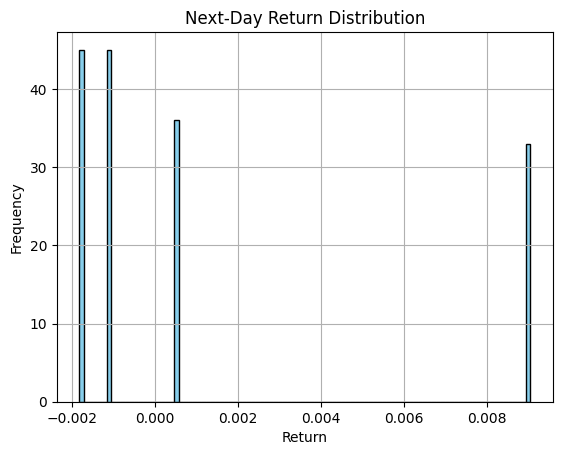

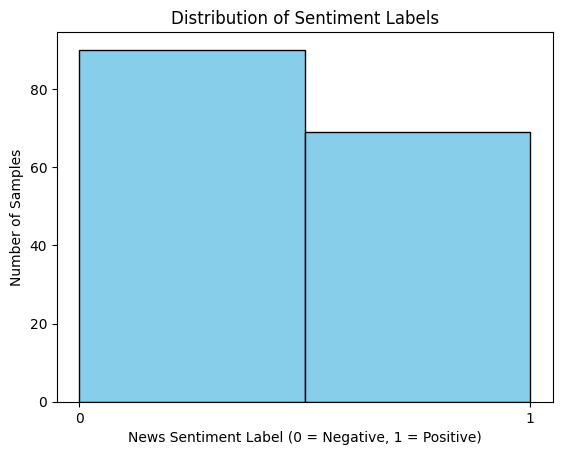

news_df columns: Index(['date', 'headline', 'summary'], dtype='object')
         date                                           headline  \
0  2025-07-27  EPU: Peru Isn't One Of My Top LatAm Picks Righ...   
1  2025-07-26   Fidelity Large Cap Stock Fund Q2 2025 Commentary   
2  2025-07-26                   Fidelity Fund Q2 2025 Commentary   
3  2025-07-26  Tea App Was Meant to Protect Women. It Couldn’...   
4  2025-07-26  Data Science Course FAANG Interview Prep 2025 ...   

                                             summary  
0  Peru's political instability and upcoming elec...  
1                                                     
2  Fidelity Investments reviews Q2 fund performan...  
3  Tea—a viral new app that’s meant to make women...  
4  Santa Clara, July 26, 2025 (GLOBE NEWSWIRE) --...  
                   datetime  \
0 2025-07-18 00:00:00+00:00   
1 2025-07-18 00:00:00+00:00   
2 2025-07-18 00:00:00+00:00   
3 2025-07-18 00:00:00+00:00   
4 2025-07-18 00:00:00+00:00   

  

In [ ]:
def get_company_news(symbol="AAPL", from_date="2025-01-26", to_date="2025-07-26"):
    url = f"https://finnhub.io/api/v1/company-news?symbol={symbol}&from={from_date}&to={to_date}&token={FINNHUB_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        news_df = pd.DataFrame(news_data)

        # Convert timestamp to datetime.date
        news_df['date'] = pd.to_datetime(news_df['datetime'], unit='s').dt.date
        return news_df[['date', 'headline', 'summary']]
    else:
        print(f"Error fetching news: {response.status_code}")
        return pd.DataFrame()

def get_price_data(ticker="AAPL", start_date="2023-01-26", end_date="2025-07-26"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df['Date']).dt.date
    return df[['Date', 'date', 'Close']]

def attach_returns(news_df, price_df):
    price_df.set_index('date', inplace=True)
    returns = []

    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            today_price = price_df.loc[news_date]['Close']
            next_day = news_date + timedelta(days=1)
            next_price = price_df.loc[next_day]['Close']
            ret = (next_price - today_price) / today_price
            returns.append(ret)
        except KeyError:
            returns.append(None)

    news_df['next_day_return'] = returns
    return news_df.dropna(subset=['next_day_return'])

def attach_labels(news_df, price_df):
    price_df.set_index('date', inplace=True)
    labels = []

    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            today_price = price_df.loc[news_date]['Close']
            next_day = news_date + timedelta(days=1)
            next_price = price_df.loc[next_day]['Close']
            ret = (next_price - today_price) / today_price

            # Assign label based on return direction
            label = 1 if ret > 0 else 0
            labels.append(label)
        except KeyError:
            labels.append(None)

    news_df['label'] = labels
    return news_df.dropna(subset=['label'])


def plot_return_distribution(news_with_returns):
    plt.hist(news_with_returns['next_day_return'], bins=100, color='skyblue', edgecolor='black')
    plt.title("Next-Day Return Distribution")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.hist(news_with_returns['label'], bins=2, color='skyblue', edgecolor='black')
    plt.xticks([0, 1])
    plt.xlabel('News Sentiment Label (0 = Negative, 1 = Positive)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Sentiment Labels')
    plt.show()
def clip_outliers(df, z_thresh=3):
    return df.apply(lambda x: x[(np.abs(x - x.mean()) / x.std()) < z_thresh])


news_df = get_company_news("AAPL", "2025-01-26", "2025-07-26")
price_df = get_price_data("AAPL", "2025-01-26", "2025-07-26")


labeled_df = attach_returns(news_df.copy(), price_df.copy())
labeled_df = attach_labels(labeled_df.copy(), price_df.copy())

# Now visualize return distribution
plot_return_distribution(labeled_df)


print("news_df columns:", news_df.columns)
print(news_df.head())

import numpy as np
import pandas as pd

def compute_log_returns(price_df):
    price_df['log_return'] = np.log(price_df['Close'] / price_df['Close'].shift(1))
    return price_df

def zscore_normalize_returns(price_df, window=30):
    price_df['zscore_return'] = (
        (price_df['log_return'] - price_df['log_return'].rolling(window).mean()) /
        price_df['log_return'].rolling(window).std()
    )
    return price_df

def attach_classification_labels(news_df, price_df, threshold=0.0):
    # Prepare news dataframe
    news_df = news_df.copy()
    news_df.rename(columns={'date': 'datetime'}, inplace=True)
    news_df['datetime'] = pd.to_datetime(news_df['datetime']).dt.tz_localize('UTC')

    # Prepare price dataframe
    price_df = price_df.copy()
    price_df['Date'] = pd.to_datetime(price_df['Date']).dt.tz_convert('UTC')

    # Calculate returns and normalize
    price_df = compute_log_returns(price_df)
    price_df = zscore_normalize_returns(price_df)

    # Use next day's return for prediction
    price_df['next_day_return'] = price_df['zscore_return'].shift(-1)

    # Convert to classification labels
    price_df['label'] = (price_df['next_day_return'] > threshold).astype(int)

    # Merge with news
    merged = pd.merge_asof(
        news_df.sort_values('datetime'),
        price_df[['Date', 'label', 'next_day_return']].sort_values('Date'),
        left_on='datetime',
        right_on='Date',
        direction='forward'
    )

    return merged.dropna(subset=['label'])

# 3. Attach regression labels (z-score log returns)
news_with_labels = attach_classification_labels(news_df, price_df)


# 4. View result
print(news_with_labels[['datetime', 'headline', 'label', 'next_day_return']].head())


In [ ]:
import re
from transformers import AutoTokenizer

# Load tokenizer for classification model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Step 1: Clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s\.\,\-]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# Step 2: Tokenize for classification
def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Step 3: Preprocess function for classification pipeline
def preprocess_news_text(news_df):
    # Clean text
    news_df["cleaned_text"] = news_df["headline"].apply(clean_text)

    # Tokenize cleaned headlines
    tokenized = tokenize_texts(news_df["cleaned_text"].tolist())

    return news_df, tokenized


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# ✅ Step 3: Preprocess text (clean + tokenize)
import re

# Apply text preprocessing function to the news DataFrame
news_with_labels, tokenized_headlines = preprocess_news_text(news_with_labels)

# Display the first 5 rows to verify cleaned and labeled data
print("\n🔍 Sample cleaned & labeled news data:")
print(news_with_labels[['datetime', 'headline', 'cleaned_text', 'target']].head())

# Display keys from the tokenized output (e.g., input_ids, attention_mask)
print("\n🔑 Tokenized keys:")
print(list(tokenized_headlines.keys()))



🔍 Sample cleaned & labeled news data:
                   datetime  \
0 2025-07-18 00:00:00+00:00   
1 2025-07-18 00:00:00+00:00   
2 2025-07-18 00:00:00+00:00   
3 2025-07-18 00:00:00+00:00   
4 2025-07-18 00:00:00+00:00   

                                            headline  \
0  Intel shares could squeeze higher during earni...   
1      Should You Sell Apple's Stock Before July 31?   
2  Top Stock Reports for Apple, JPMorgan Chase & ...   
3  Apple races ahead in epic $150M F1 media right...   
4  Jim Cramer Says “Apple Can Change Course” By A...   

                                        cleaned_text  label  
0  Intel shares could squeeze higher during earni...    1.0  
1        Should You Sell Apples Stock Before July 31    1.0  
2   Top Stock Reports for Apple, JPMorgan Chase Visa    1.0  
3  Apple races ahead in epic 150M F1 media rights...    1.0  
4  Jim Cramer Says Apple Can Change Course By Acq...    1.0  

🔑 Tokenized keys:
['input_ids', 'token_type_ids', 'attention_mas

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipython-input-2667044721.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
/tmp/ipython-input-2667044721.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
Epoch 1: 100%|██████████| 12/12 [00:02<00:00,  5.98it/s]


Epoch 1 - Training Loss: 0.6696


Epoch 2: 100%|██████████| 12/12 [00:01<00:00, 11.13it/s]


Epoch 2 - Training Loss: 0.6141


Epoch 3: 100%|██████████| 12/12 [00:01<00:00, 10.94it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Epoch 3 - Training Loss: 0.5804

Test Accuracy: 0.7234

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        34
    Positive       0.00      0.00      0.00        13

    accuracy                           0.72        47
   macro avg       0.36      0.50      0.42        47
weighted avg       0.52      0.72      0.61        47



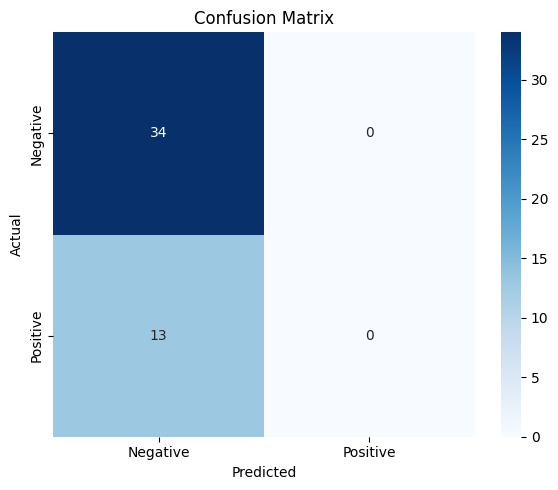

In [ ]:
# ✅ Step 1: Imports and Setup
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Step 2: Define Dataset
class NewsClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# ✅ Step 3: Define Classification Model
class DistilBertClassifier(nn.Module):
    def __init__(self):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        return self.classifier(pooled_output)

# ✅ Step 4: Tokenize & Split
if 'cleaned_text' not in news_with_labels.columns:
    raise ValueError("Missing 'cleaned_text' column. Run preprocessing step first.")

encoded = tokenizer(list(news_with_labels['cleaned_text']), padding=True, truncation=True, return_tensors='pt')
labels = news_with_labels['label'].values.astype(int)

# Filter out invalid entries
valid_indices = np.isin(labels, [0, 1])
labels = labels[valid_indices]
encoded = {k: v[valid_indices] for k, v in encoded.items()}

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    encoded['input_ids'], encoded['attention_mask'], labels, test_size=0.2, random_state=42
)

X_train = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
X_test = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

# ✅ Step 5: Create Dataloaders
train_dataset = NewsClassificationDataset(X_train, y_train)
test_dataset = NewsClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# ✅ Step 6: Train
model = DistilBertClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

# ✅ Step 7: Evaluate
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

# ✅ Step 8: Metrics
accuracy = accuracy_score(actuals, predictions)
report = classification_report(actuals, predictions, target_names=['Negative', 'Positive'])

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# ✅ Step 9: Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

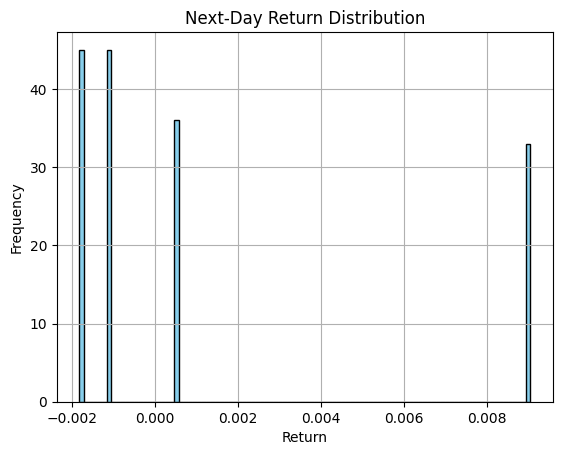

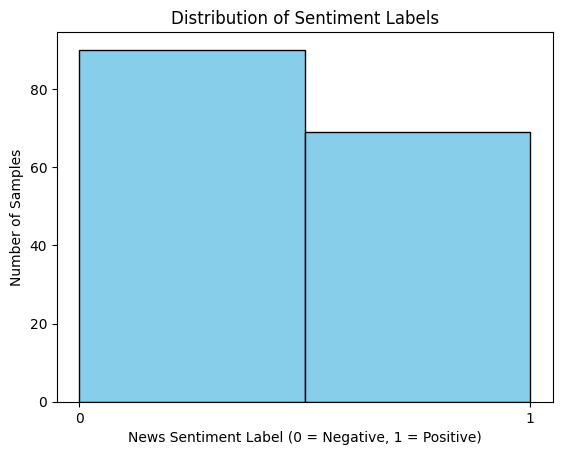

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipython-input-3074204363.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
/tmp/ipython-input-3074204363.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 1 - Training Loss: 0.5891


Epoch 2: 100%|██████████| 16/16 [00:01<00:00, 12.50it/s]


Epoch 2 - Training Loss: 0.5065


Epoch 3: 100%|██████████| 16/16 [00:01<00:00, 12.38it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Epoch 3 - Training Loss: 0.5020

Test Accuracy: 0.7234

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        34
    Positive       0.00      0.00      0.00        13

    accuracy                           0.72        47
   macro avg       0.36      0.50      0.42        47
weighted avg       0.52      0.72      0.61        47



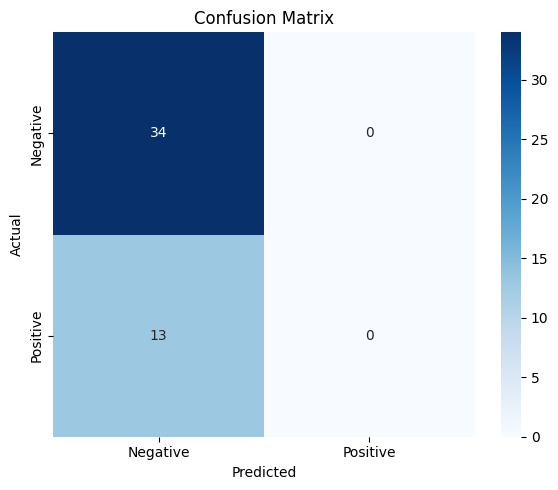

In [ ]:
import requests
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from imblearn.over_sampling import SMOTE
import numpy as np
import re
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# ===== Your Finnhub API Key =====
FINNHUB_API_KEY = "d22c559r01qt8677r440d22c559r01qt8677r44g"

# ============================
# Data fetching functions
# ============================
def get_company_news(symbol="AAPL", from_date="2025-01-26", to_date="2025-07-26"):
    url = f"https://finnhub.io/api/v1/company-news?symbol={symbol}&from={from_date}&to={to_date}&token={FINNHUB_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        news_df = pd.DataFrame(news_data)
        news_df['date'] = pd.to_datetime(news_df['datetime'], unit='s').dt.date
        return news_df[['date', 'headline', 'summary']]
    else:
        print(f"Error fetching news: {response.status_code}")
        return pd.DataFrame()

def get_price_data(ticker="AAPL", start_date="2023-01-26", end_date="2025-07-26"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df['Date']).dt.date
    return df[['Date', 'date', 'Close']]

def attach_returns(news_df, price_df):
    price_df.set_index('date', inplace=True)
    returns = []
    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            today_price = price_df.loc[news_date]['Close']
            next_day = news_date + timedelta(days=1)
            next_price = price_df.loc[next_day]['Close']
            ret = (next_price - today_price) / today_price
            returns.append(ret)
        except KeyError:
            returns.append(None)
    news_df['next_day_return'] = returns
    return news_df.dropna(subset=['next_day_return'])

def attach_labels(news_df, price_df):
    price_df.set_index('date', inplace=True)
    labels = []
    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            today_price = price_df.loc[news_date]['Close']
            next_day = news_date + timedelta(days=1)
            next_price = price_df.loc[next_day]['Close']
            ret = (next_price - today_price) / today_price
            label = 1 if ret > 0 else 0
            labels.append(label)
        except KeyError:
            labels.append(None)
    news_df['label'] = labels
    return news_df.dropna(subset=['label'])

def plot_return_distribution(news_with_returns):
    plt.hist(news_with_returns['next_day_return'], bins=100, color='skyblue', edgecolor='black')
    plt.title("Next-Day Return Distribution")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.hist(news_with_returns['label'], bins=2, color='skyblue', edgecolor='black')
    plt.xticks([0, 1])
    plt.xlabel('News Sentiment Label (0 = Negative, 1 = Positive)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Sentiment Labels')
    plt.show()

def compute_log_returns(price_df):
    price_df['log_return'] = np.log(price_df['Close'] / price_df['Close'].shift(1))
    return price_df

def zscore_normalize_returns(price_df, window=30):
    price_df['zscore_return'] = (
        (price_df['log_return'] - price_df['log_return'].rolling(window).mean()) /
        price_df['log_return'].rolling(window).std()
    )
    return price_df

def attach_classification_labels(news_df, price_df, threshold=0.0):
    news_df = news_df.copy()
    news_df['date'] = pd.to_datetime(news_df['date']).dt.tz_localize('UTC')

    price_df = price_df.copy()
    price_df['Date'] = pd.to_datetime(price_df['Date']).dt.tz_convert('UTC')

    price_df = compute_log_returns(price_df)
    price_df = zscore_normalize_returns(price_df)

    price_df['next_day_return'] = price_df['zscore_return'].shift(-1)
    price_df['label'] = (price_df['next_day_return'] > threshold).astype(int)

    merged = pd.merge_asof(
        news_df.sort_values('date'),
        price_df[['Date', 'label', 'next_day_return']].sort_values('Date'),
        left_on='date',
        right_on='Date',
        direction='forward'
    )

    return merged.dropna(subset=['label'])

# ============================
# Text preprocessing
# ============================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s\.\,\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

def preprocess_news_text(news_df):
    news_df["cleaned_text"] = news_df["headline"].apply(clean_text)
    tokenized = tokenize_texts(news_df["cleaned_text"].tolist())
    return news_df, tokenized

# ============================
# Data Fetch & Labeling
# ============================
news_df = get_company_news("AAPL", "2025-01-26", "2025-07-26")
price_df = get_price_data("AAPL", "2025-01-26", "2025-07-26")
labeled_df = attach_returns(news_df.copy(), price_df.copy())
labeled_df = attach_labels(labeled_df.copy(), price_df.copy())
plot_return_distribution(labeled_df)
news_with_labels = attach_classification_labels(news_df, price_df)
news_with_labels, tokenized_headlines = preprocess_news_text(news_with_labels)

# ============================
# Dataset & Model
# ============================
class NewsClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

class DistilBertClassifier(nn.Module):
    def __init__(self):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        return self.classifier(pooled_output)

# ============================
# Step 4: Tokenize, Split, SMOTE
# ============================
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

if 'cleaned_text' not in news_with_labels.columns:
    raise ValueError("Missing 'cleaned_text' column. Run preprocessing step first.")

encoded = tokenizer(list(news_with_labels['cleaned_text']), padding=True, truncation=True, return_tensors='np')
labels = news_with_labels['label'].values.astype(int)

X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    encoded['input_ids'], encoded['attention_mask'], labels, test_size=0.2, random_state=42
)

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_flat = X_train_ids.reshape(X_train_ids.shape[0], -1)
X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train)

# Reshape back to original transformer input shape
seq_len = X_train_ids.shape[1]
X_train_ids_res = X_train_res[:, :seq_len]
X_train_mask_res = X_train_res[:, seq_len:]

# Prepare dataloaders
train_dataset = NewsClassificationDataset(
    {'input_ids': torch.tensor(X_train_ids_res, dtype=torch.long),
     'attention_mask': torch.tensor(X_train_mask_res, dtype=torch.long)},
    y_train_res
)

test_dataset = NewsClassificationDataset(
    {'input_ids': torch.tensor(X_test_ids, dtype=torch.long),
     'attention_mask': torch.tensor(X_test_mask, dtype=torch.long)},
    y_test
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# ============================
# Training
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

# ============================
# Evaluation
# ============================
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

accuracy = accuracy_score(actuals, predictions)
report = classification_report(actuals, predictions, target_names=['Negative', 'Positive'])

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

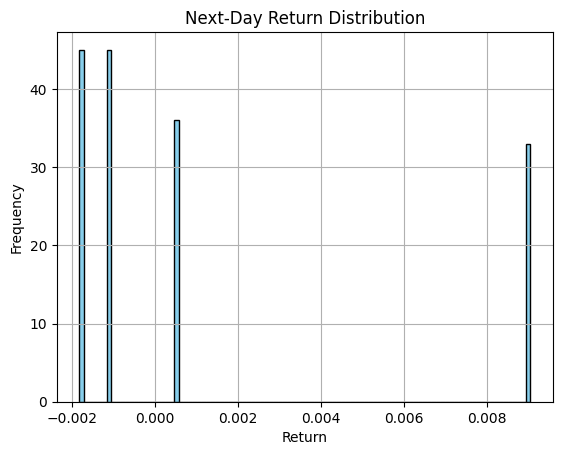

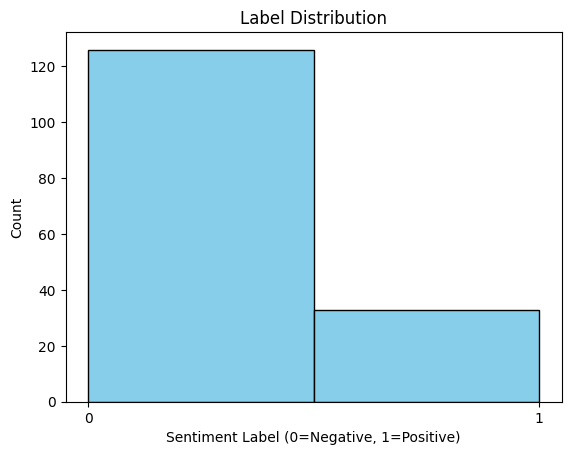

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


Epoch 1 Loss: 0.6176


Epoch 2: 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]


Epoch 2 Loss: 0.5139


Epoch 3: 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

Epoch 3 Loss: 0.4806

Test Accuracy: 0.7188

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      1.00      0.84        23
    Positive       0.00      0.00      0.00         9

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32



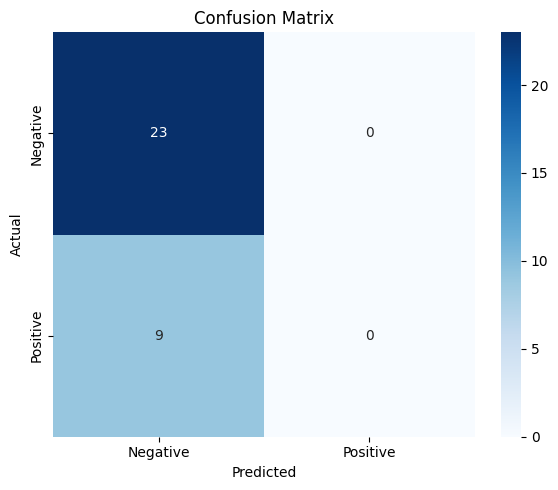

In [ ]:
import requests
import yfinance as yf
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import numpy as np
import re
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# ===== Your Finnhub API Key =====
FINNHUB_API_KEY = "d22c559r01qt8677r440d22c559r01qt8677r44g"

# ============================
# Data fetching functions
# ============================
def fetch_company_news(symbol="AAPL", start_date="2025-01-26", end_date="2025-07-26"):
    url = f"https://finnhub.io/api/v1/company-news?symbol={symbol}&from={start_date}&to={end_date}&token={FINNHUB_API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        news_json = response.json()
        news_df = pd.DataFrame(news_json)
        news_df['date'] = pd.to_datetime(news_df['datetime'], unit='s').dt.date
        return news_df[['date', 'headline', 'summary']]
    else:
        print(f"Error fetching news: {response.status_code}")
        return pd.DataFrame()

def fetch_price_data(ticker="AAPL", start_date="2025-01-26", end_date="2025-07-26"):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df['Date']).dt.date
    return df[['Date', 'date', 'Close']]

def calculate_next_day_returns(news_df, price_df):
    price_df = price_df.set_index('date')
    returns = []
    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            price_today = price_df.loc[news_date]['Close']
            price_next_day = price_df.loc[news_date + timedelta(days=1)]['Close']
            ret = (price_next_day - price_today) / price_today
            returns.append(ret)
        except KeyError:
            returns.append(None)
    news_df['next_day_return'] = returns
    return news_df.dropna(subset=['next_day_return'])

def assign_class_labels(news_df, price_df, threshold=0.005):
    # threshold is 0.5% return to label positive class; else negative
    price_df = price_df.set_index('date')
    labels = []
    for _, row in news_df.iterrows():
        news_date = row['date']
        try:
            price_today = price_df.loc[news_date]['Close']
            price_next_day = price_df.loc[news_date + timedelta(days=1)]['Close']
            ret = (price_next_day - price_today) / price_today
            label = 1 if ret > threshold else 0
            labels.append(label)
        except KeyError:
            labels.append(None)
    news_df['label'] = labels
    return news_df.dropna(subset=['label'])

def plot_distributions(dataframe):
    plt.hist(dataframe['next_day_return'], bins=100, color='skyblue', edgecolor='black')
    plt.title("Next-Day Return Distribution")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    plt.hist(dataframe['label'], bins=2, color='skyblue', edgecolor='black')
    plt.xticks([0,1])
    plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

# ============================
# Text preprocessing
# ============================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s\.\,\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(news_df):
    # Combine headline and summary for richer context
    news_df['combined_text'] = news_df.apply(
        lambda x: (str(x['headline']) + " " + str(x['summary'])), axis=1
    )
    news_df['cleaned_text'] = news_df['combined_text'].apply(clean_text)
    return news_df

def tokenize_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# ============================
# Dataset & Model
# ============================
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

class DistilBertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:,0]
        return self.classifier(pooled)

# ============================
# Main Pipeline
# ============================
news_raw = fetch_company_news("AAPL", "2025-01-26", "2025-07-26")
price_raw = fetch_price_data("AAPL", "2025-01-26", "2025-07-26")

news_with_returns = calculate_next_day_returns(news_raw.copy(), price_raw.copy())
news_with_labels = assign_class_labels(news_with_returns.copy(), price_raw.copy(), threshold=0.005)

plot_distributions(news_with_labels)

news_with_labels = preprocess_text(news_with_labels)
texts = news_with_labels['cleaned_text'].tolist()
labels = news_with_labels['label'].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

train_encodings = tokenizer(
    train_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_encodings = tokenizer(
    test_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train model
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])

print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:\n", report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
print(Counter(y_train))  # or use: np.unique(y_train, return_counts=True)



Counter({np.int64(0): 127, np.int64(1): 59})
